In [1]:
%load_ext autoreload
%autoreload 2

# Set Trial Name

In [2]:
TRIAL_NAME = "3_change_target_rmsle"

import datetime
import pytz
NOW = datetime.datetime.now(pytz.timezone('Asia/Tokyo')).strftime('%Y%m%d%H%M%S')

# Load yaml

In [3]:
import yaml
CONFIG_DIR = '../config'
with open(f'{CONFIG_DIR}/run000.yml') as file:
    cfg = yaml.safe_load(file)

import sys
sys.path.append(cfg['SRC_DIR'])
cfg['run_name'] = TRIAL_NAME

# fix seed

In [4]:
from util import seed_everything
seed_everything(seed=33, use_torch=False)

# Make Output Folder

In [5]:
import os
OUTPUT_DIR = f'../../output/{NOW}_{TRIAL_NAME}'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load Model

In [6]:
import pandas as pd
sub = pd.read_csv('../../data/atmacup10__sample_submission.csv')
color = pd.read_csv('../../data/color.csv')
historical_person = pd.read_csv('../../data/historical_person.csv')
maker = pd.read_csv('../../data/maker.csv')
material = pd.read_csv('../../data/material.csv')
object_collection = pd.read_csv('../../data/object_collection.csv')
palette = pd.read_csv('../../data/palette.csv')
principal_maker_occupation = pd.read_csv('../../data/principal_maker_occupation.csv')
principal_maker = pd.read_csv('../../data/principal_maker.csv')
production_place = pd.read_csv('../../data/production_place.csv')
technique = pd.read_csv('../../data/technique.csv')
test = pd.read_csv('../../data/test.csv')
train = pd.read_csv('../../data/train.csv')

# train

In [7]:
train['likes'].min()

0

In [8]:
train.head(2)

,object_id,art_series_id,title,description,long_title,principal_maker,principal_or_first_maker,sub_title,copyright_holder,more_title,acquisition_method,acquisition_date,acquisition_credit_line,dating_presenting_date,dating_sorting_date,dating_period,dating_year_early,dating_year_late,likes
0,0011d6be41612ec9eae3,93c092ba70beab248f31,The Avenue of Birches,NaN,"The Avenue of Birches, Jan Hackaert, 1660 - 1685",Jan Hackaert,Jan Hackaert,h 66.5cm × w 53.7cm × t 2.5cm × d 4.7cm,NaN,The Avenue of Birches,purchase,1808-01-01T00:00:00,NaN,1660 - 1685,1660.0,17,1660.0,1685.0,48
1,0012765f7a97ccc3e9e9,95c14fb11c54281ad7e0,Struik in bloei,NaN,"Struik in bloei, Richard Tepe (attributed to),...",Richard Tepe,Richard Tepe,h 165mm × w 223mm,erven Richard Tepe,Struik in bloei,purchase,2000-01-01T00:00:00,NaN,c. 1900 - c. 1930,1900.0,19,1900.0,1930.0,2


In [9]:
test.head(2)

,object_id,art_series_id,title,description,long_title,principal_maker,principal_or_first_maker,sub_title,copyright_holder,more_title,acquisition_method,acquisition_date,acquisition_credit_line,dating_presenting_date,dating_sorting_date,dating_period,dating_year_early,dating_year_late
0,000405d9a5e3f49fc49d,a2aabd3cc8859f4260ad,Twee personen voor de Duizendjarige den te Wol...,NaN,Twee personen voor de Duizendjarige den te Wol...,Bernardus Bruining,Bernardus Bruining,h 167mm × w 108mm,NaN,Twee personen voor de Duizendjarige den te Wol...,transfer,1994-01-01T00:00:00,NaN,1850 - 1900,1850.0,19,1850.0,1900.0
1,001020bd00b149970f78,5d6a286cc3ab64c2c043,"Portrait of Philipp Ernst, Count of Hohenlohe ...","Portret van Philip Ernst (1585-1629), graaf va...","Portrait of Philipp Ernst, Count of Hohenlohe ...",Jan Antonisz van Ravesteyn,Jan Antonisz van Ravesteyn,h 29.7cm × w 24.1cm,NaN,"Portrait of Philipp Ernst, Count of Hohenlohe ...",nationalization 1795,1798-09-01T00:00:00,NaN,c. 1609 - c. 1633,1609.0,17,1609.0,1633.0


# reduce mem usage

In [10]:
# from util import reduce_mem_usage
# train_feat_df = reduce_mem_usage(train_feat_df)
# test_feat_df = reduce_mem_usage(test_feat_df)

# del not common value between train and test

In [11]:
train.columns

Index(['object_id', 'art_series_id', 'title', 'description', 'long_title',
       'principal_maker', 'principal_or_first_maker', 'sub_title',
       'copyright_holder', 'more_title', 'acquisition_method',
       'acquisition_date', 'acquisition_credit_line', 'dating_presenting_date',
       'dating_sorting_date', 'dating_period', 'dating_year_early',
       'dating_year_late', 'likes'],
      dtype='object')

In [12]:
del_non_overlapping_list = [
    'object_id',
    'art_series_id',
    'title',
    'description',
    'long_title',
    'principal_maker',
    'principal_or_first_maker',
    'sub_title',
    'copyright_holder',
    'more_title',
    'acquisition_method',
    'acquisition_date',
    'acquisition_credit_line',
    'dating_presenting_date',
    'dating_sorting_date',
    'dating_period',
    'dating_year_early',
    'dating_year_late'
]

from util import replace_non_overlap_val_to_missing
train, test = replace_non_overlap_val_to_missing(train,test,columns=del_non_overlapping_list)

# Lable Encoding

In [13]:
cat_col = train.select_dtypes('O').columns.tolist()

In [14]:
from fe import label_encode
train, test = label_encode(train, test, cat_col)

In [15]:
train.dtypes

object_id                     int64
art_series_id                 int64
title                         int64
description                   int64
long_title                    int64
principal_maker               int64
principal_or_first_maker      int64
sub_title                     int64
copyright_holder              int64
more_title                    int64
acquisition_method            int64
acquisition_date              int64
acquisition_credit_line       int64
dating_presenting_date        int64
dating_sorting_date         float64
dating_period                 int64
dating_year_early           float64
dating_year_late            float64
likes                         int64
dtype: object

# add fold

In [16]:
from fold import add_fold_bin_skf
train = add_fold_bin_skf(train, train[cfg['target']], fold_num=5, bins=[0,1,10,100,1000, 27392])

# Make Model

In [17]:
use_col = train.columns.tolist()
use_col.remove('fold')
use_col.remove(cfg['target'])

In [18]:
use_col

['object_id',
 'art_series_id',
 'title',
 'description',
 'long_title',
 'principal_maker',
 'principal_or_first_maker',
 'sub_title',
 'copyright_holder',
 'more_title',
 'acquisition_method',
 'acquisition_date',
 'acquisition_credit_line',
 'dating_presenting_date',
 'dating_sorting_date',
 'dating_period',
 'dating_year_early',
 'dating_year_late']

In [19]:
# 学習直前でwandbにログイン、こうしないと頻繁にnotebookが落ちる
from use_wandb import use_wandb
use_wandb(params=cfg['params'], PROJECT_NAME=cfg['competition_name'], TRIAL_NAME=TRIAL_NAME)

wandb: Currently logged in as: sinchir0 (use `wandb login --relogin` to force relogin)


/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/__init__.py:42: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  warnings.warn("Starting from version 2.2.1, the library file in distribution wheels for macOS "
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anac

--------------FOLDS : 0 --------------
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.3269	valid_1's rmse: 1.36284
[200]	training's rmse: 1.19585	valid_1's rmse: 1.25147
[300]	training's rmse: 1.14126	valid_1's rmse: 1.213
[400]	training's rmse: 1.11127	valid_1's rmse: 1.19962
[500]	training's rmse: 1.09083	valid_1's rmse: 1.19204
[600]	training's rmse: 1.07406	valid_1's rmse: 1.187
[700]	training's rmse: 1.06001	valid_1's rmse: 1.18426
[800]	training's rmse: 1.04687	valid_1's rmse: 1.18136
[900]	training's rmse: 1.03551	valid_1's rmse: 1.17901
[1000]	training's rmse: 1.02472	valid_1's rmse: 1.17776
[1100]	training's rmse: 1.01458	valid_1's rmse: 1.17626
[1200]	training's rmse: 1.00501	valid_1's rmse: 1.17466
[1300]	training's rmse: 0.996308	valid_1's rmse: 1.17323
[1400]	training's rmse: 0.988042	valid_1's rmse: 1.17114
[1500]	training's rmse: 0.98043	valid_1's rmse: 1.17054
[1600]	training's rmse: 0.973026	valid_1's rmse: 1.1695
[1700]	training

/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1246: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_credit_line', 'acquisition_date', 'acquisition_method', 'art_series_id', 'copyright_holder', 'dating_presenting_date', 'description', 'long_title', 'more_title', 'object_id', 'principal_maker', 'principal_or_first_maker', 'sub_title', 'title']
  warnings.warn('categorical_feature in Datase

[100]	training's rmse: 1.323	valid_1's rmse: 1.35832
[200]	training's rmse: 1.19047	valid_1's rmse: 1.25565
[300]	training's rmse: 1.13732	valid_1's rmse: 1.22619
[400]	training's rmse: 1.10809	valid_1's rmse: 1.21354
[500]	training's rmse: 1.08803	valid_1's rmse: 1.20683
[600]	training's rmse: 1.0714	valid_1's rmse: 1.20183
[700]	training's rmse: 1.05741	valid_1's rmse: 1.1972
[800]	training's rmse: 1.04458	valid_1's rmse: 1.19303
[900]	training's rmse: 1.03309	valid_1's rmse: 1.19026
[1000]	training's rmse: 1.02228	valid_1's rmse: 1.18799
[1100]	training's rmse: 1.01229	valid_1's rmse: 1.18552
[1200]	training's rmse: 1.0028	valid_1's rmse: 1.18287
[1300]	training's rmse: 0.993962	valid_1's rmse: 1.18134
[1400]	training's rmse: 0.985524	valid_1's rmse: 1.18006
[1500]	training's rmse: 0.977635	valid_1's rmse: 1.17907
[1600]	training's rmse: 0.969748	valid_1's rmse: 1.17751
[1700]	training's rmse: 0.962512	valid_1's rmse: 1.17674
[1800]	training's rmse: 0.955763	valid_1's rmse: 1.1757
[

/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1246: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_credit_line', 'acquisition_date', 'acquisition_method', 'art_series_id', 'copyright_holder', 'dating_presenting_date', 'description', 'long_title', 'more_title', 'object_id', 'principal_maker', 'principal_or_first_maker', 'sub_title', 'title']
  warnings.warn('categorical_feature in Datase

[100]	training's rmse: 1.33378	valid_1's rmse: 1.32734
[200]	training's rmse: 1.20329	valid_1's rmse: 1.20805
[300]	training's rmse: 1.14966	valid_1's rmse: 1.16993
[400]	training's rmse: 1.12103	valid_1's rmse: 1.15523
[500]	training's rmse: 1.10132	valid_1's rmse: 1.14764
[600]	training's rmse: 1.08555	valid_1's rmse: 1.14191
[700]	training's rmse: 1.07138	valid_1's rmse: 1.13775
[800]	training's rmse: 1.05871	valid_1's rmse: 1.13545
[900]	training's rmse: 1.04741	valid_1's rmse: 1.13295
[1000]	training's rmse: 1.03635	valid_1's rmse: 1.13067
[1100]	training's rmse: 1.02656	valid_1's rmse: 1.12896
[1200]	training's rmse: 1.01693	valid_1's rmse: 1.12769
[1300]	training's rmse: 1.00818	valid_1's rmse: 1.12573
[1400]	training's rmse: 0.999717	valid_1's rmse: 1.12442
[1500]	training's rmse: 0.991852	valid_1's rmse: 1.12321
[1600]	training's rmse: 0.984423	valid_1's rmse: 1.12253
[1700]	training's rmse: 0.97742	valid_1's rmse: 1.12185
[1800]	training's rmse: 0.970683	valid_1's rmse: 1.121

/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1246: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_credit_line', 'acquisition_date', 'acquisition_method', 'art_series_id', 'copyright_holder', 'dating_presenting_date', 'description', 'long_title', 'more_title', 'object_id', 'principal_maker', 'principal_or_first_maker', 'sub_title', 'title']
  warnings.warn('categorical_feature in Datase

[100]	training's rmse: 1.32315	valid_1's rmse: 1.36626
[200]	training's rmse: 1.18946	valid_1's rmse: 1.25771
[300]	training's rmse: 1.1373	valid_1's rmse: 1.22209
[400]	training's rmse: 1.1086	valid_1's rmse: 1.20767
[500]	training's rmse: 1.08892	valid_1's rmse: 1.19943
[600]	training's rmse: 1.07269	valid_1's rmse: 1.19437
[700]	training's rmse: 1.05855	valid_1's rmse: 1.19087
[800]	training's rmse: 1.04574	valid_1's rmse: 1.18705
[900]	training's rmse: 1.03417	valid_1's rmse: 1.18405
[1000]	training's rmse: 1.0234	valid_1's rmse: 1.18193
[1100]	training's rmse: 1.01333	valid_1's rmse: 1.17936
[1200]	training's rmse: 1.0042	valid_1's rmse: 1.17742
[1300]	training's rmse: 0.995558	valid_1's rmse: 1.17609
[1400]	training's rmse: 0.987179	valid_1's rmse: 1.1746
[1500]	training's rmse: 0.979491	valid_1's rmse: 1.17308
[1600]	training's rmse: 0.971908	valid_1's rmse: 1.17183
[1700]	training's rmse: 0.964721	valid_1's rmse: 1.17131
[1800]	training's rmse: 0.957702	valid_1's rmse: 1.17081


/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1246: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_credit_line', 'acquisition_date', 'acquisition_method', 'art_series_id', 'copyright_holder', 'dating_presenting_date', 'description', 'long_title', 'more_title', 'object_id', 'principal_maker', 'principal_or_first_maker', 'sub_title', 'title']
  warnings.warn('categorical_feature in Datase

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.32613	valid_1's rmse: 1.35588
[200]	training's rmse: 1.19291	valid_1's rmse: 1.24308
[300]	training's rmse: 1.13868	valid_1's rmse: 1.20704
[400]	training's rmse: 1.10974	valid_1's rmse: 1.19368
[500]	training's rmse: 1.08955	valid_1's rmse: 1.18739
[600]	training's rmse: 1.07367	valid_1's rmse: 1.18395
[700]	training's rmse: 1.05925	valid_1's rmse: 1.18066
[800]	training's rmse: 1.04645	valid_1's rmse: 1.17855
[900]	training's rmse: 1.03464	valid_1's rmse: 1.17613
[1000]	training's rmse: 1.02393	valid_1's rmse: 1.17427
[1100]	training's rmse: 1.01391	valid_1's rmse: 1.17281
[1200]	training's rmse: 1.00462	valid_1's rmse: 1.17117
[1300]	training's rmse: 0.995677	valid_1's rmse: 1.17037
[1400]	training's rmse: 0.987349	valid_1's rmse: 1.1695
[1500]	training's rmse: 0.979174	valid_1's rmse: 1.16867
[1600]	training's rmse: 0.971298	valid_1's rmse: 1.16878
Early stopping, best iteration is:
[1520]	traini

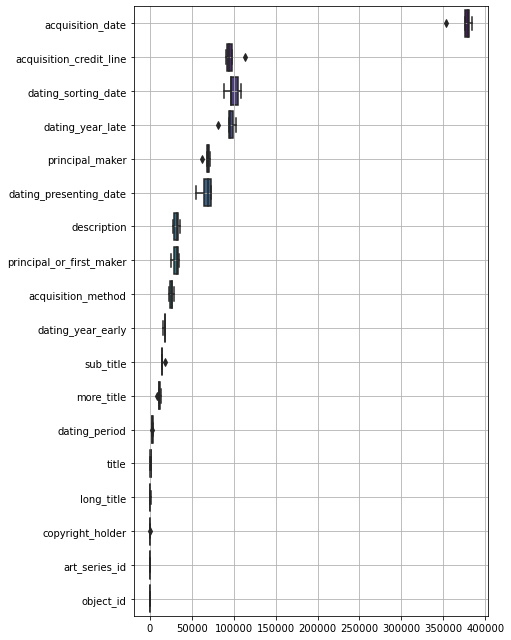

In [20]:
from fe import target_encoding
from lgbm import LGBM

lgbm = LGBM(train=train,
  test=test,
  target='likes',
  use_col=use_col,
  cat_col=cat_col,
  cfg=cfg,
  OUTPUT_DIR=OUTPUT_DIR,
  DO_FIT=True,
  DO_SEED_AVE=False,
  DEBUG=False,
  is_target_log=True)

feature_importance_df, order = lgbm.feature_importance()

In [21]:
from make_data import make_oof
oof_df = make_oof(OUTPUT_DIR=OUTPUT_DIR, TARGET=cfg['target'])

In [22]:
# from score import calc_macro_auc
# score = calc_macro_auc(train_target_df=train_target_df, oof_df=oof_df, order_list=TARGET_IDS)

In [23]:
sample_sub = pd.read_csv('../../data/atmacup10__sample_submission.csv')

In [24]:
from make_data import make_sub
sub_df = make_sub(sample_sub=sample_sub, TARGET_NAME=cfg['target'], TRIAL_NAME=TRIAL_NAME, OUTPUT_DIR=OUTPUT_DIR, cv_score=lgbm.score)

QUick Sub
sh sub.sh output/20210307123337_3_change_target_rmsle/pred/pred_likes_1.1582.csv


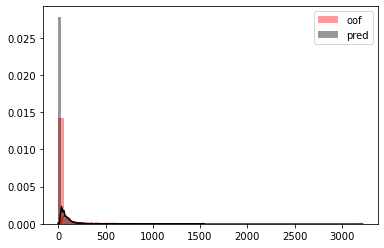

In [25]:
from make_fig import make_dist_oof_pred
make_dist_oof_pred(oof_df=oof_df,sub_df=sub_df,OUTPUT_DIR=OUTPUT_DIR)